# ResNet-50 with Data Augmentation

Building on the baseline model with advanced data augmentation techniques to improve generalization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import json
import os

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce GTX 960M


**Data Augmentation Transforms**

In [9]:
# ImageNet normalization values
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transform WITH augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation/Test transform (same as baseline)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transforms defined!")
print("✓ Using mild augmentation for better generalization")

Transforms defined!
✓ Using mild augmentation for better generalization


**Load Dataset**

In [10]:
data_path = '../dataset'

# Load full dataset first (without transform)
full_dataset_no_transform = datasets.ImageFolder(root=data_path)

print(f"Total images: {len(full_dataset_no_transform)}")
print(f"Classes: {full_dataset_no_transform.classes}")
print(f"Class to index: {full_dataset_no_transform.class_to_idx}")

Total images: 13902
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic']
Class to index: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}


In [11]:
# Split: 60% Train, 20% Validation, 20% Test
total_size = len(full_dataset_no_transform)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Use same seed as baseline for fair comparison
torch.manual_seed(42)
indices = torch.randperm(total_size).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

print(f"Train size: {len(train_indices)}")
print(f"Validation size: {len(val_indices)}")
print(f"Test size: {len(test_indices)}")

Train size: 8341
Validation size: 2780
Test size: 2781


In [12]:
# Create datasets with appropriate transforms
# Training set: WITH augmentation
train_dataset_full = datasets.ImageFolder(root=data_path, transform=train_transform)
train_dataset = Subset(train_dataset_full, train_indices)

# Validation and Test sets: WITHOUT augmentation
val_test_dataset_full = datasets.ImageFolder(root=data_path, transform=val_test_transform)
val_dataset = Subset(val_test_dataset_full, val_indices)
test_dataset = Subset(val_test_dataset_full, test_indices)

# Create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 4  # Parallel CPU workers for data loading & augmentation

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Using {NUM_WORKERS} CPU workers for parallel data loading")

Train batches: 261
Validation batches: 87
Test batches: 87
Using 4 CPU workers for parallel data loading


**Augmented Samples**

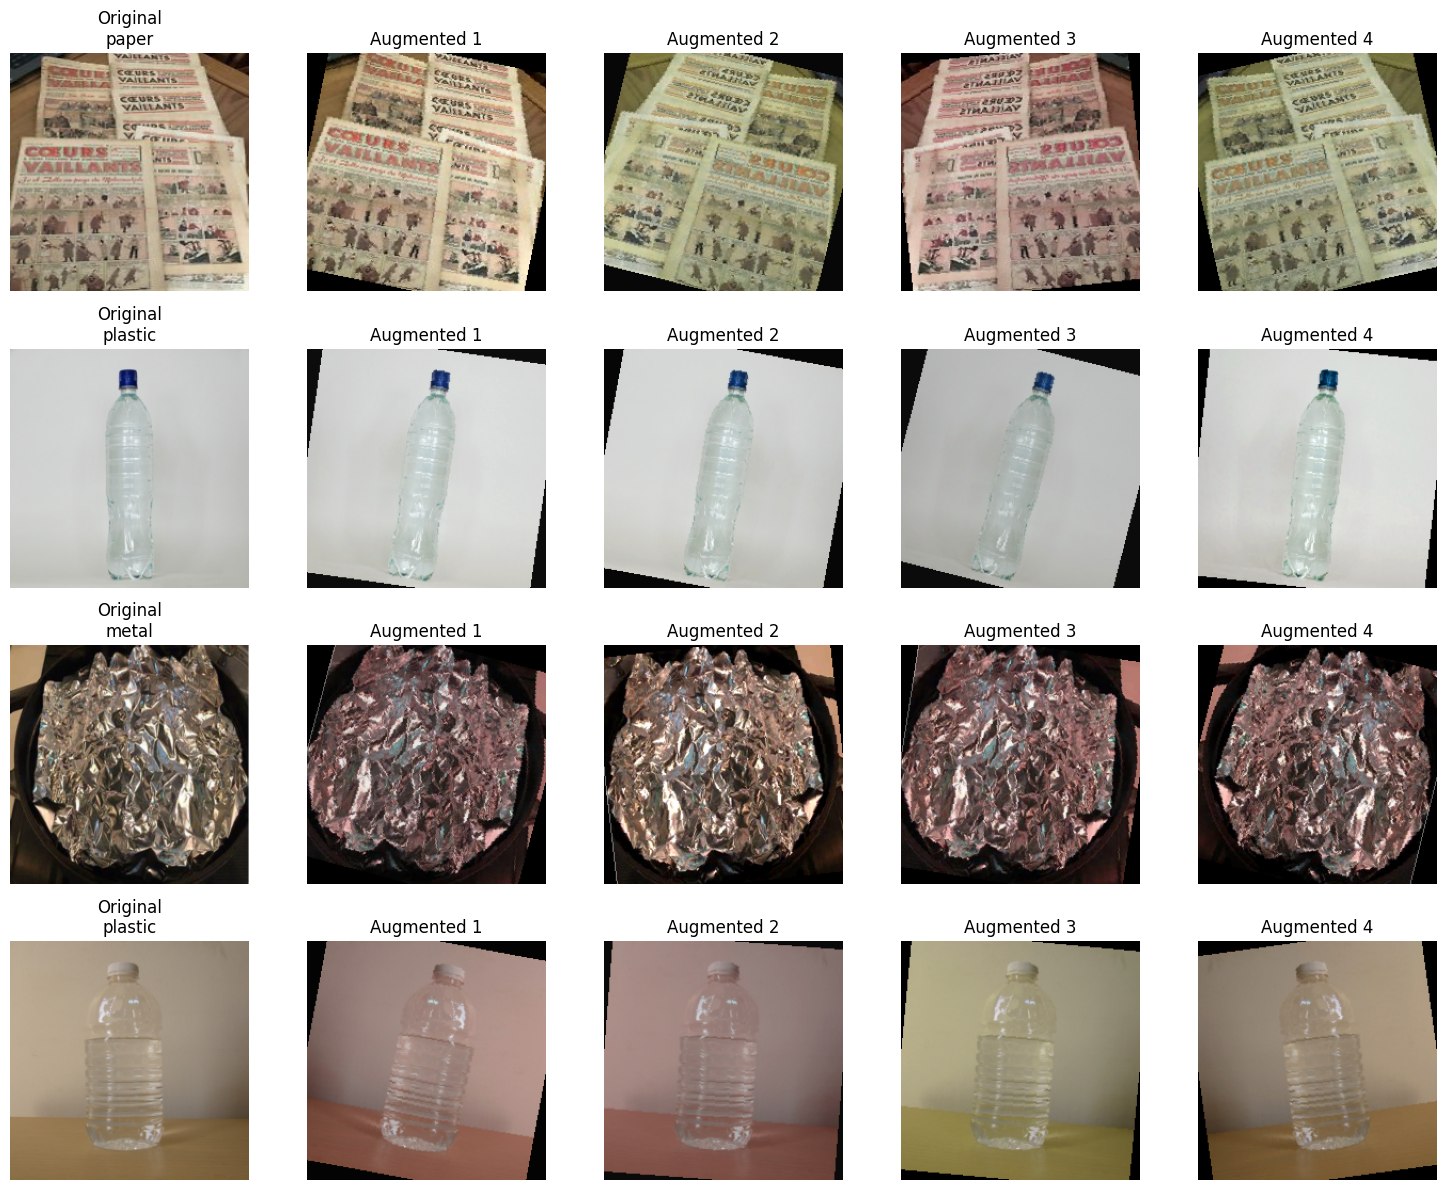

In [17]:
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def show_augmented_samples(dataset, num_samples=4, num_augmentations=4):
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, figsize=(15, 3*num_samples))
    
    # Get original dataset (without augmentation) for comparison
    original_dataset = datasets.ImageFolder(root=data_path, transform=val_test_transform)
    class_names = original_dataset.classes
    
    for i in range(num_samples):
        idx = train_indices[i * 40]
        
        # Original image
        orig_img, label = original_dataset[idx+10]
        axes[i, 0].imshow(denormalize(orig_img).permute(1, 2, 0))
        axes[i, 0].set_title(f'Original\n{class_names[label]}')
        axes[i, 0].axis('off')
        
        # Augmented versions
        for j in range(num_augmentations):
            aug_img, _ = train_dataset_full[idx+10]
            axes[i, j+1].imshow(denormalize(aug_img).permute(1, 2, 0))
            axes[i, j+1].set_title(f'Augmented {j+1}')
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.savefig('../plots/augmentation_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

show_augmented_samples(train_dataset, num_samples=4, num_augmentations=4)

**Model Setup**

In [18]:
def create_resnet50(num_classes=5, pretrained=True):
    if pretrained:
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        model = models.resnet50(weights=weights)
    else:
        model = models.resnet50(weights=None)
    
    # Replace final FC layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    
    return model


model = create_resnet50(num_classes=5, pretrained=True)
model = model.to(device)

print(f"Model loaded on {device}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model loaded on cuda

Total parameters: 23,518,277
Trainable parameters: 23,518,277


**Training Setup**

In [19]:
# Hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15
WEIGHT_DECAY = 1e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

print("Training configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Batch size: {BATCH_SIZE}")

Training configuration:
  Learning rate: 0.0001
  Epochs: 15
  Weight decay: 0.0001
  Batch size: 32


**Training and Validation Functions**

In [20]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

**Training Loop**

In [21]:
# History for plotting
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_model_path = '../best_model/best_resnet50_augmented15.pth'
history_path = '../results/augmented_history15.json'
patience_counter = 0
EARLY_STOP_PATIENCE = 5

print("="*60)
print("TRAINING RESNET-50 WITH DATA AUGMENTATION")
print("="*60)
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} , Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} , Val Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)
        print(f"  → New best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

total_time = time.time() - start_time
print("="*60)
print(f"Training completed in {total_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

# Save training history to file
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to {history_path}")

TRAINING RESNET-50 WITH DATA AUGMENTATION
Epoch [ 1/15] | Train Loss: 0.5426 , Train Acc: 81.36% | Val Loss: 0.2278 , Val Acc: 92.16% | Time: 770.9s
  → New best model saved! (Val Acc: 92.16%)
Epoch [ 2/15] | Train Loss: 0.1701 , Train Acc: 94.50% | Val Loss: 0.1375 , Val Acc: 95.76% | Time: 425.2s
  → New best model saved! (Val Acc: 95.76%)
Epoch [ 3/15] | Train Loss: 0.0998 , Train Acc: 96.81% | Val Loss: 0.1299 , Val Acc: 96.12% | Time: 417.3s
  → New best model saved! (Val Acc: 96.12%)
Epoch [ 4/15] | Train Loss: 0.0793 , Train Acc: 97.28% | Val Loss: 0.1184 , Val Acc: 96.37% | Time: 387.2s
  → New best model saved! (Val Acc: 96.37%)
Epoch [ 5/15] | Train Loss: 0.0648 , Train Acc: 97.79% | Val Loss: 0.1270 , Val Acc: 96.37% | Time: 385.4s


KeyboardInterrupt: 

**Plot Training History**

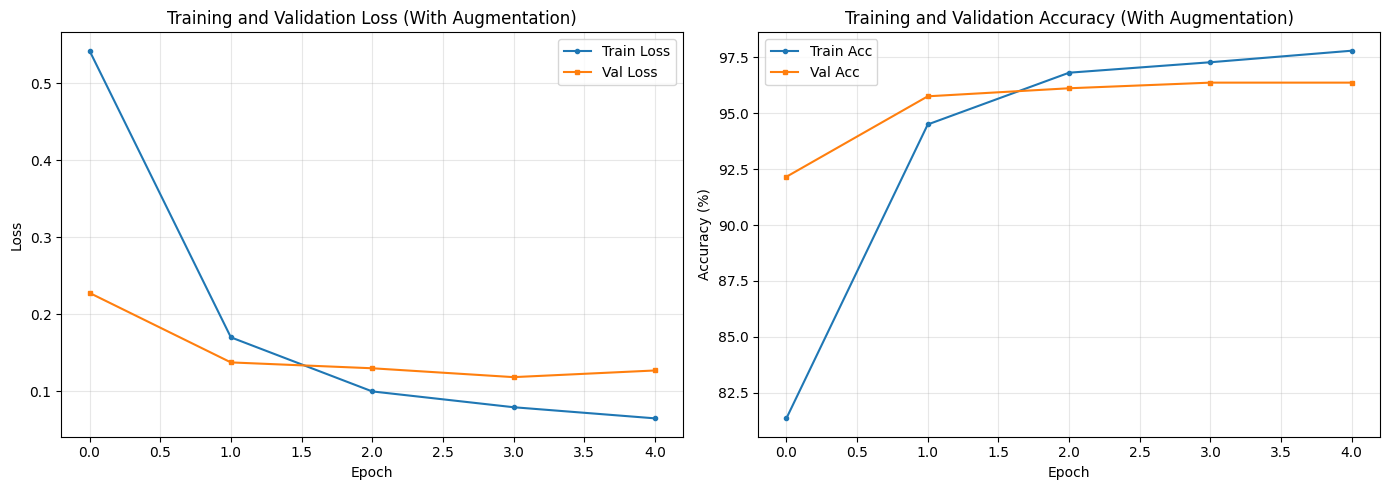

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss (With Augmentation)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o', markersize=3)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy (With Augmentation)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/training_history_augmented_withoutCropping.png', dpi=150, bbox_inches='tight')
plt.show()

**Evaluate on Test Set**

**Run this section if VS Code crashed or you want to evaluate without retraining.**  
If you run this model once, this cell loads the saved model and history from disk - no need to run training cells again!

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, Subset
# from torchvision import datasets, transforms, models
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import json
# import os

# # Setup Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Paths
# data_path = '../dataset-resized'
# best_model_path = '../best_model/best_resnet50_augmented15.pth'
# history_path = '../results/augmented_history15.json'

# # Check if saved files exist
# if not os.path.exists(best_model_path):
#     raise FileNotFoundError(f"Model not found at {best_model_path}. Please run training first!")

# # ImageNet normalization
# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD = [0.229, 0.224, 0.225]

# # Validation/Test transform
# val_test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
# ])

# # Recreate test dataset with same split
# full_dataset_no_transform = datasets.ImageFolder(root=data_path)
# total_size = len(full_dataset_no_transform)
# train_size = int(0.7 * total_size)
# val_size = int(0.15 * total_size)

# torch.manual_seed(42)  # Same seed as training
# indices = torch.randperm(total_size).tolist()
# test_indices = indices[train_size + val_size:]

# val_test_dataset_full = datasets.ImageFolder(root=data_path, transform=val_test_transform)
# test_dataset = Subset(val_test_dataset_full, test_indices)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# # Create model architecture
# def create_resnet50(num_classes=6):
#     model = models.resnet50(weights=None)
#     num_features = model.fc.in_features
#     model.fc = nn.Sequential(
#         nn.Dropout(0.5),
#         nn.Linear(num_features, num_classes)
#     )
#     return model

# model = create_resnet50(num_classes=6)
# model = model.to(device)

# # Load saved checkpoint
# checkpoint = torch.load(best_model_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# print(f"✓ Model loaded from epoch {checkpoint['epoch']+1}")
# print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")

# best_val_acc = checkpoint['val_acc']

# # Load training history (if exists)
# if os.path.exists(history_path):
#     with open(history_path, 'r') as f:
#         history = json.load(f)
#     print(f"Training history loaded ({len(history['train_loss'])} epochs)")
# else:
#     history = None
#     print("Training history not found - plotting will be skipped")

# class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {best_val_acc:.2f}%")

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT (With Augmentation)")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    return all_labels, all_preds

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
all_labels, all_preds = evaluate_model(model, test_loader, device, class_names)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet50 with Data Augmentation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../plots/confusion_matrix_augmented15.png', dpi=150, bbox_inches='tight')
plt.show()

**Save Results**

In [ ]:
# Calculate final test accuracy
test_accuracy = 100 * sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)

epochs_trained = len(history['train_loss']) if isinstance(history, dict) and 'train_loss' in history else None

# Save results
results = {
    'model': 'ResNet50',
    'experiment': 'With Data Augmentation',
    'num_epochs_trained': epochs_trained,
    'best_val_accuracy': best_val_acc,
    'test_accuracy': test_accuracy,
    'augmentations': [
        'RandomCrop(224)',
        'RandomHorizontalFlip(p=0.5)',
        'RandomRotation(15)',
        'ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)',
        'RandomAffine(translate=0.1, scale=0.9-1.1)',
        'Normalize(ImageNet)'
    ]
}

with open('../results/augmented_results15.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to '../results/augmented_results15.json'")
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")

**Compare with Baseline**

In [ ]:
# Load baseline results for comparison
try:
    with open('../results/baseline_results.json', 'r') as f:
        baseline_results = json.load(f)
    
    print("="*60)
    print("COMPARISON: BASELINE vs DATA AUGMENTATION")
    print("="*60)
    print(f"\n{'Metric':<25} {'Baseline':>15} {'Augmented':>15} {'Difference':>15}")
    print("-"*70)
    
    baseline_val = baseline_results.get('best_val_accuracy', 0)
    baseline_test = baseline_results.get('test_accuracy', 0)
    
    print(f"{'Best Val Accuracy':<25} {baseline_val:>14.2f}% {best_val_acc:>14.2f}% {best_val_acc - baseline_val:>+14.2f}%")
    print(f"{'Test Accuracy':<25} {baseline_test:>14.2f}% {test_accuracy:>14.2f}% {test_accuracy - baseline_test:>+14.2f}%")
    
    # Bar chart comparison only
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    metrics = ['Val Accuracy', 'Test Accuracy']
    baseline_scores = [baseline_val, baseline_test]
    augmented_scores = [best_val_acc, test_accuracy]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='steelblue')
    bars2 = ax.bar(x + width/2, augmented_scores, width, label='Augmented', color='coral')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim([0, 100])
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../plots/baseline_vs_augmented_comparison15.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("Baseline results file not found. Run the baseline notebook first to enable comparison.")